# The Advanced Lane Finding

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle
from datetime import datetime

In [2]:
# a helper function to display the original image and proccessed image side by side
def display2images(left_img, right_img, left_title="Original", right_title="Processed", left_gray=False, right_gray=False):
    """
    displays two images side by side in one cell.
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if left_gray:
        ax1.imshow(left_img, cmap="gray")
    else:
        ax1.imshow(left_img)
    ax1.set_title(left_title, fontsize=50)
    if right_gray:
        ax2.imshow(right_img, cmap="gray")
    else:
        ax2.imshow(right_img)
    ax2.set_title(right_title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---

### Rubric 1-1: Camera Callibaration & undistort image

In [3]:
def calibrate_camera(calibrate_images, nx=9, ny=6):
    objpoints = []
    imgpoints = []

    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for fname in calibrate_images:
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)            
    return ret, mtx, dist, rvecs, tvecs

ret, mtx, dist, rvecs, tvecs = calibrate_camera(glob.glob("./camera_cal/calibration*.jpg"))

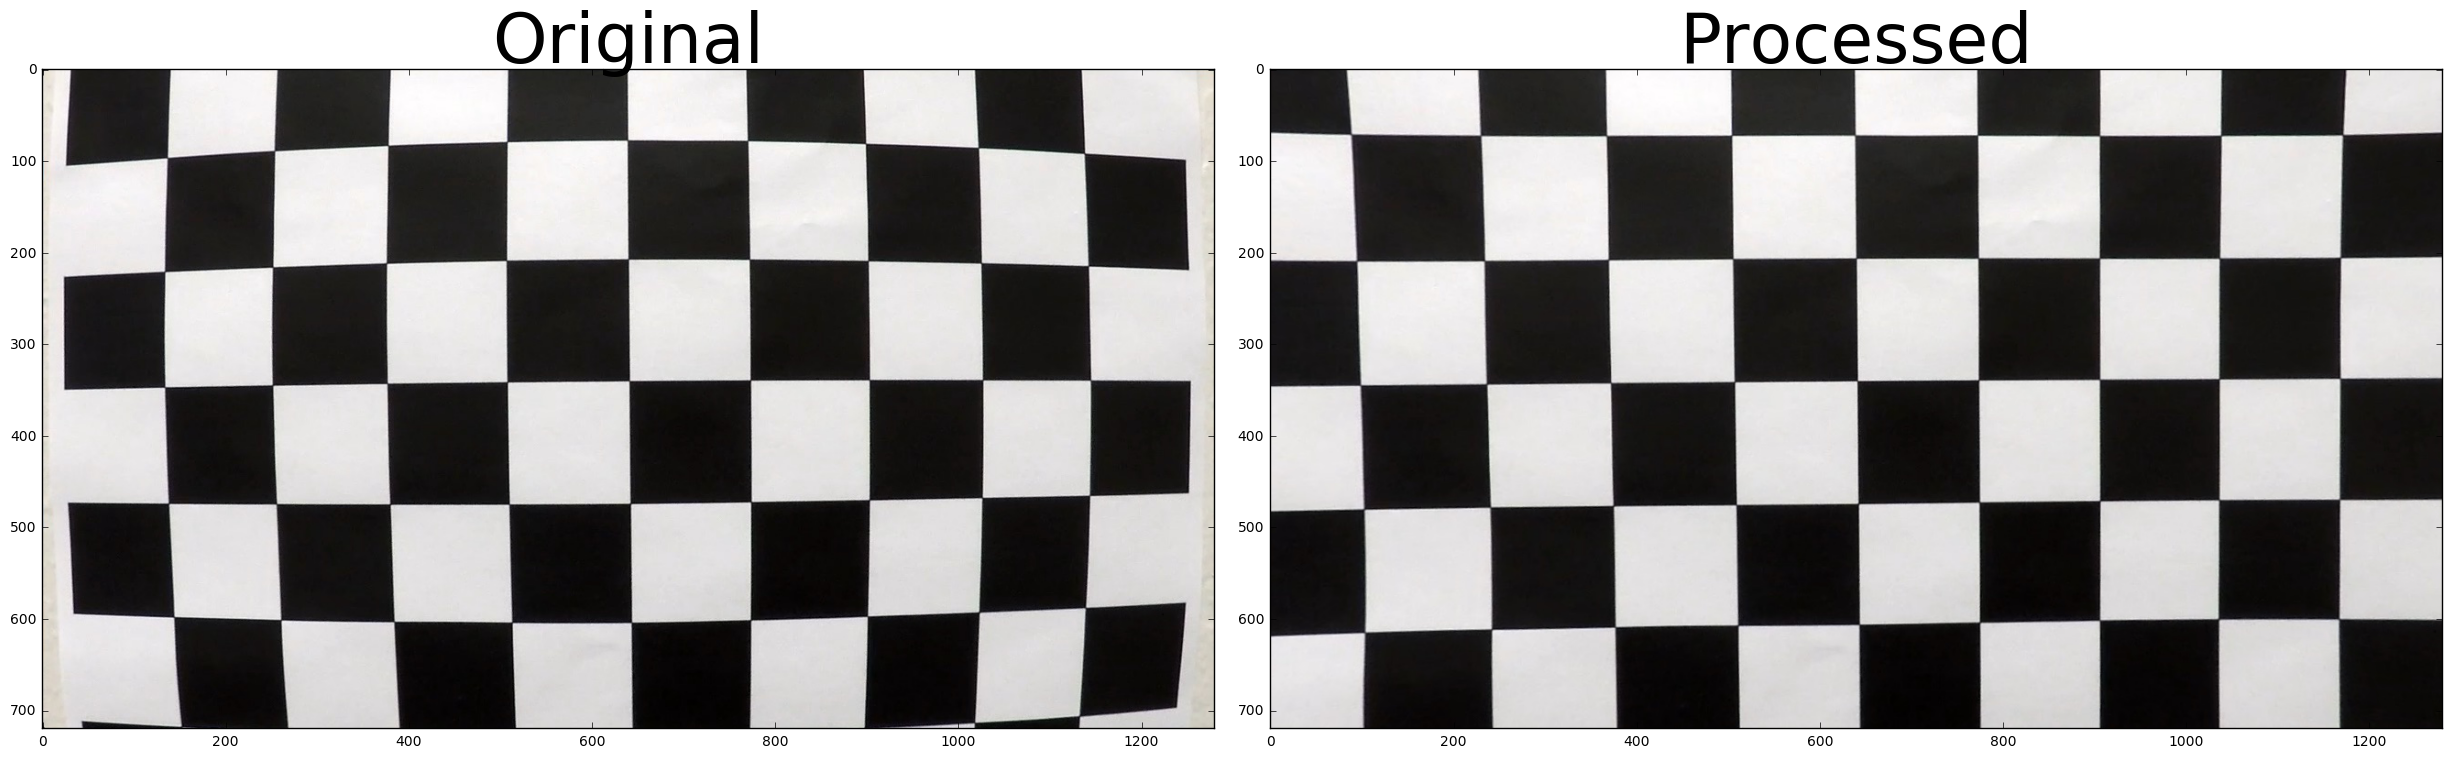

In [4]:
test_image = plt.imread('./camera_cal/calibration1.jpg')
undistored_image = cv2.undistort(test_image, mtx, dist)
display2images(test_image, undistored_image)

### Rubric 2-1: undistort a test image

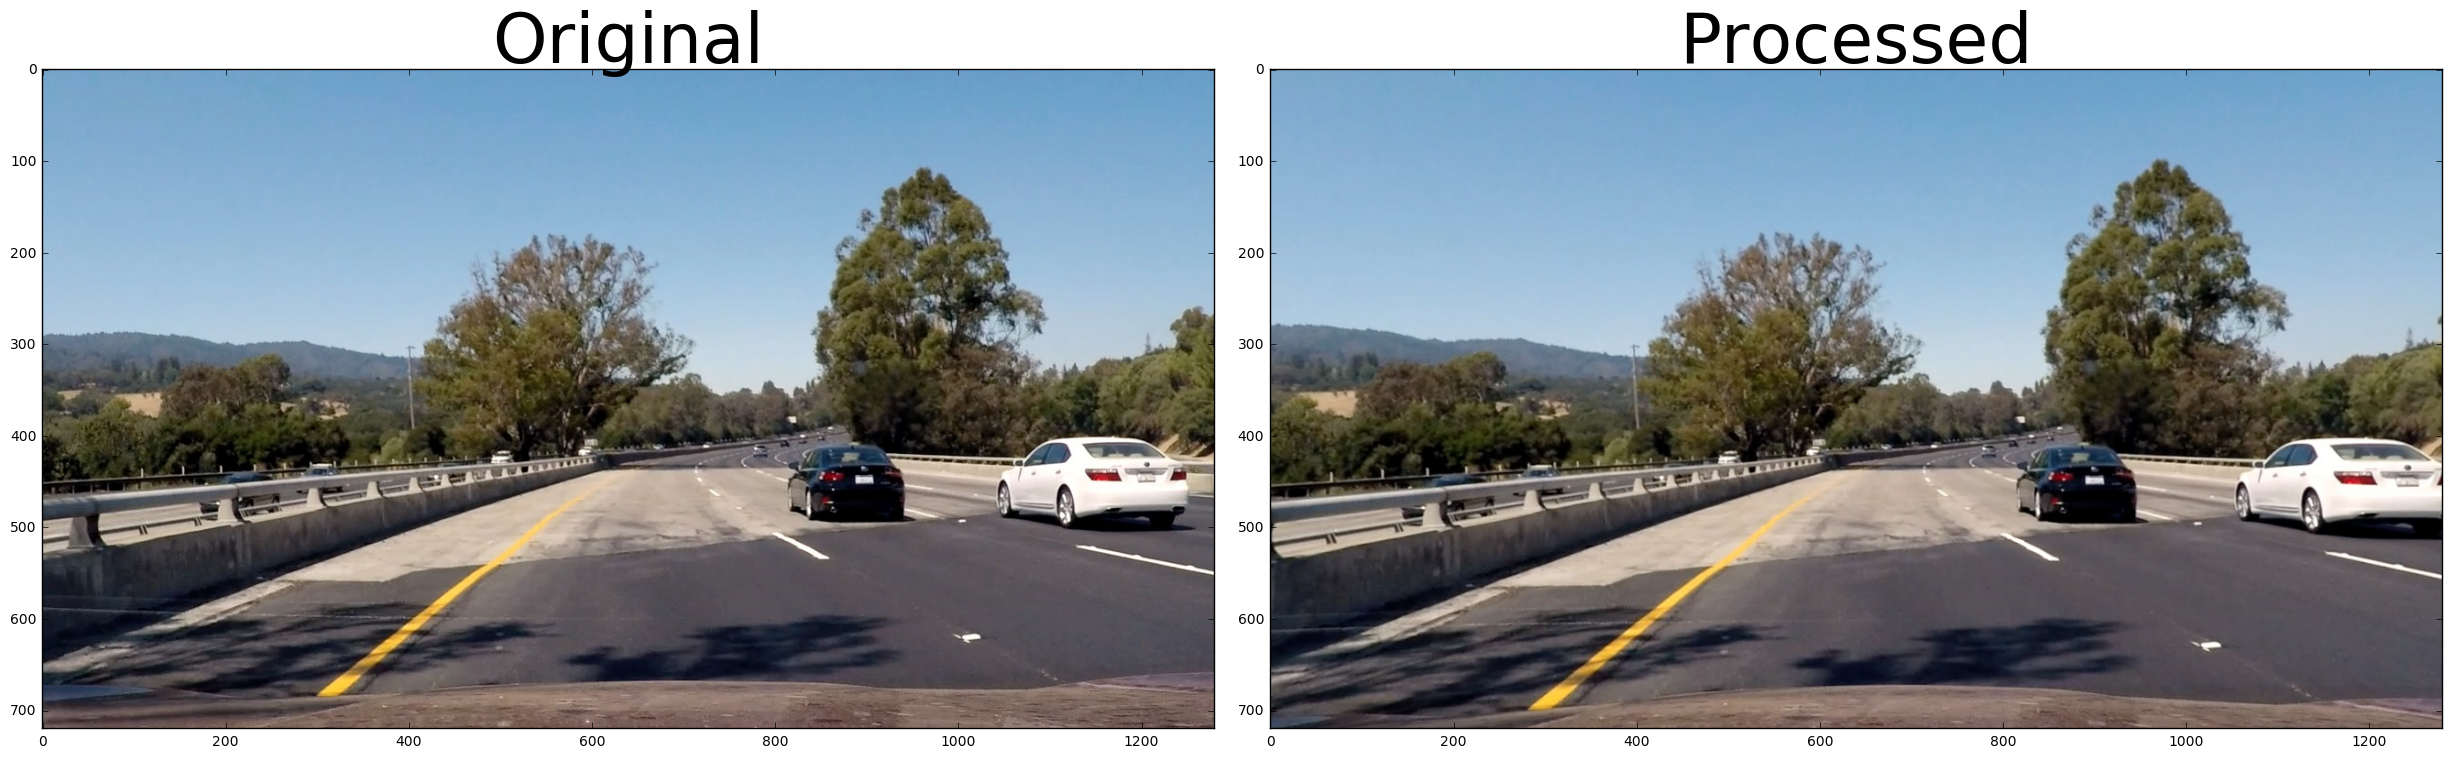

In [5]:
test_image = plt.imread('./test_images/test4.jpg')
undistored_image = cv2.undistort(test_image, mtx, dist)
display2images(test_image, undistored_image)

### Rubric 2-2: gradient and color threshold

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply cv2.Sobel()
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))    
    # Apply lower and upper thresholds
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Create binary_output
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    binary_output = np.ones_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 0
    return binary_output

# combien the threshold
def combine_thresh(img, ksize=3, sobel_thresh=(30, 255), mg_thresh=(30, 255), dir_thresh=(0, np.pi/2)):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=sobel_thresh)
    hls_binary = hls_select(img, thresh=(0, 160))
    
    combined = np.zeros_like(hls_binary)
    combined[((gradx == 1)) | (hls_binary == 1)] = 1
    return combined

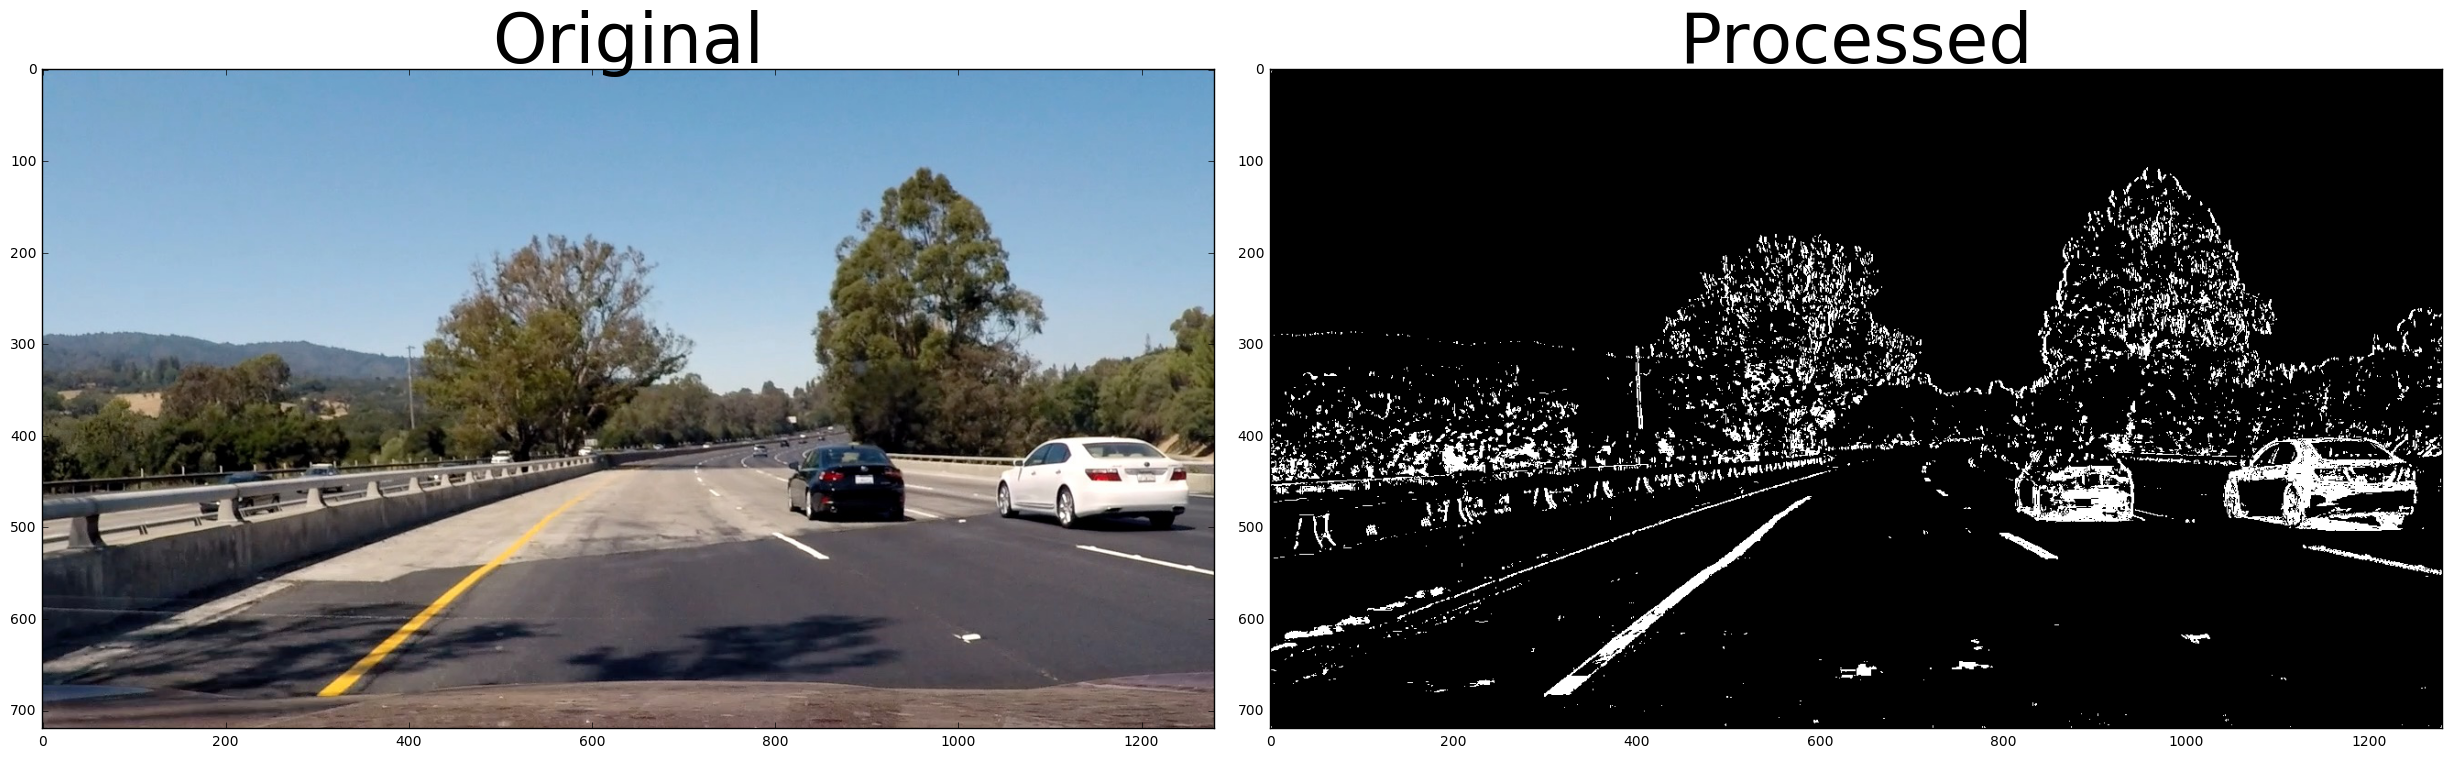

In [7]:
test_image = plt.imread("./test_images/test4.jpg")
combined_binary = combine_thresh(test_image)
display2images(test_image, combined_binary, right_gray=True)

### Rubric 2-3 perspective transform

In [139]:
def finetune_src_dst(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
            [[(img_size[0] / 2)-55, img_size[1] / 2 + 100],   # top left
            [(img_size[0] / 4)-40, img_size[1] - 50],      # bottom left
            [(img_size[0] * 5 / 6)-10, img_size[1] - 50],   # bottom right
            [(img_size[0] / 2 + 70), img_size[1] / 2 + 100]])   # top right
    
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
        
    return src, dst

def warp_image(img):
    img_size = (img.shape[1], img.shape[0])
    src, dst = finetune_src_dst(img)
    # get transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # get inverse transform matrix 
    Minv = cv2.getPerspectiveTransform(dst, src)
    # the the transformed image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return M, Minv, warped

=====Image Shape=======
(720, 1280, 3)
=====Source Points=====
( 585,  460)
( 280,  670)
(1056,  670)
( 710,  460)
== Destination Points ==
( 320,    0)
( 320,  720)
( 960,  720)
( 960,    0)


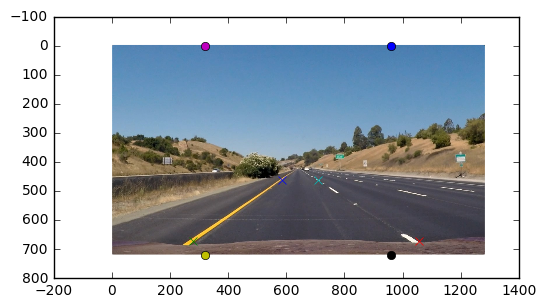

In [140]:
test_image = plt.imread("./test_images/straight_lines1.jpg")
# the source rectangle
print("=====Image Shape=======")
print(test_image.shape)
src, dst = finetune_src_dst(test_image)
plt.imshow(test_image)
print("=====Source Points=====")
for s in src:
    print("(%4d, %4d)" % (s[0], s[1]))
    plt.plot(s[0], s[1], "x")
print("== Destination Points ==")
for d in dst:
    print("(%4d, %4d)" % (d[0], d[1]))
    plt.plot(d[0], d[1], "o")

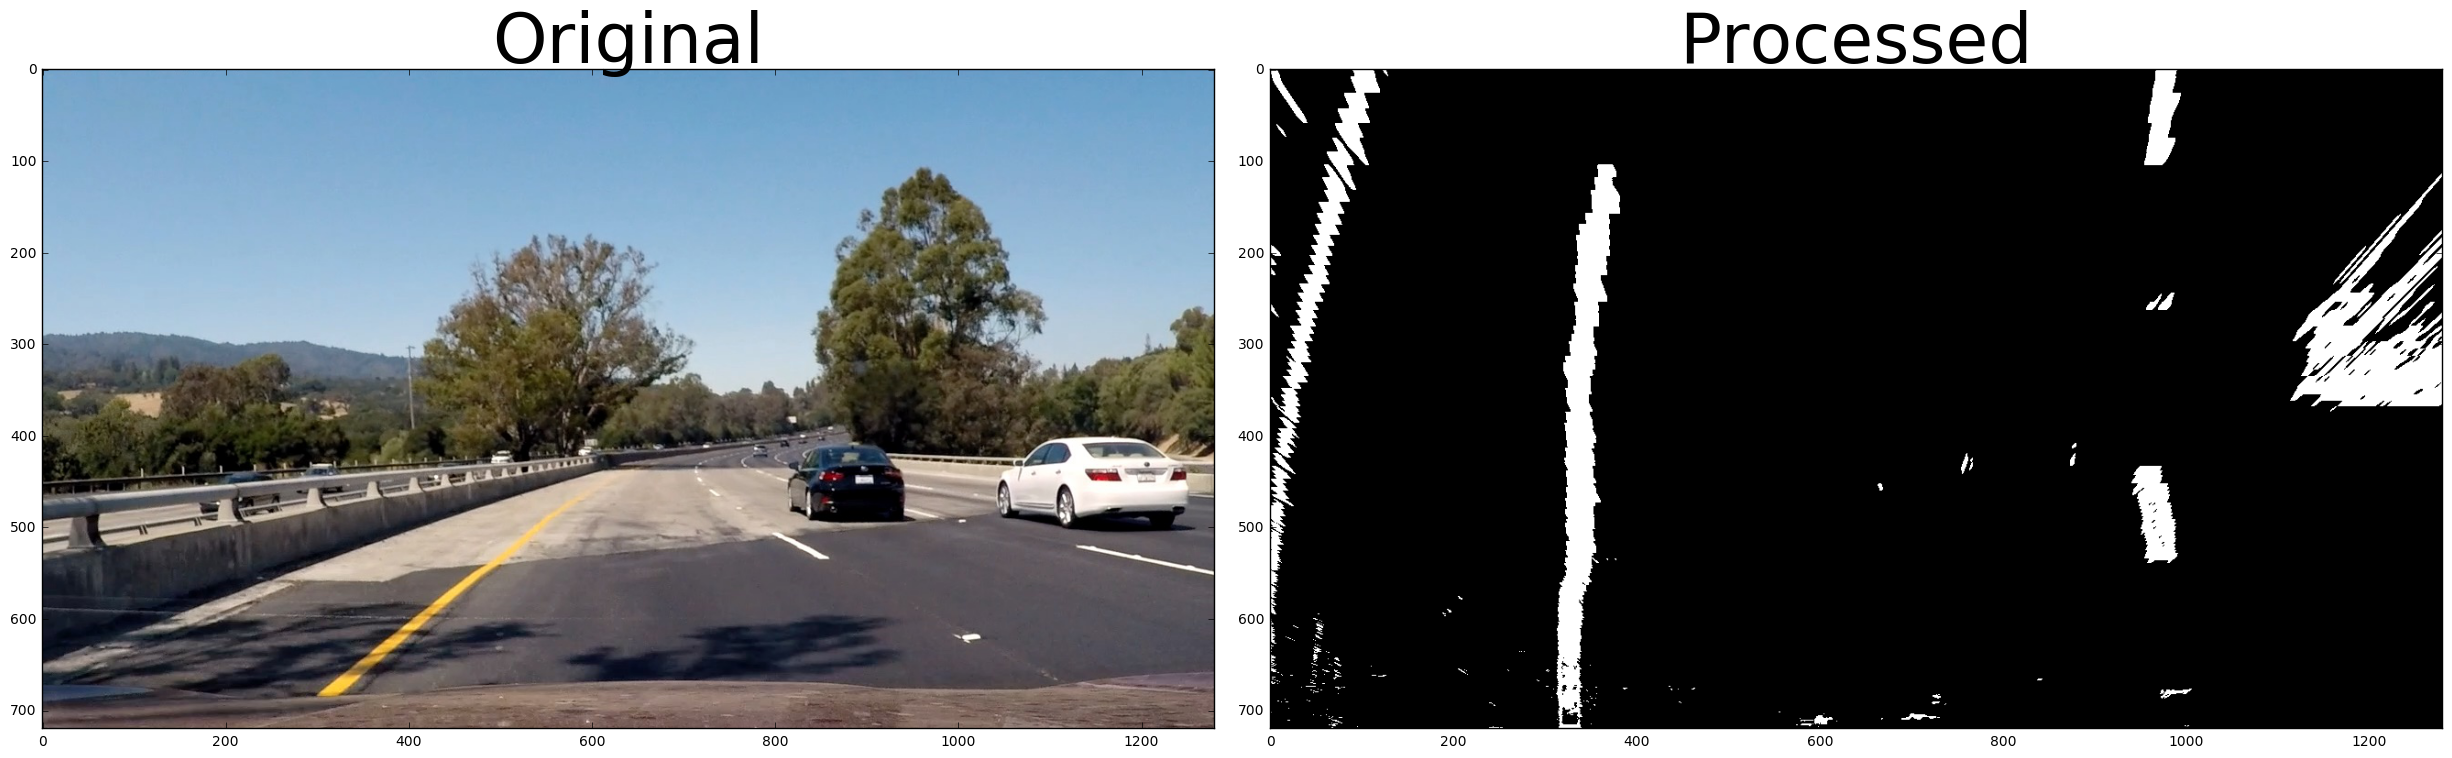

In [16]:
test_image = plt.imread("./test_images/test4.jpg")
_, Minv, warped_image = warp_image(combine_thresh(test_image))
display2images(test_image, warped_image, right_gray=True)

### Rubric 2-4, indentifying the lane line pixels

In [149]:
def fit_line(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):  
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit, right_fit)
#     return (left_fit, right_fit), (left_lane_inds, right_lane_inds), [(leftx, lefty), (rightx, righty)]

def display_the_fitted_line(binary_warped):
    
#     fit, lane_inds, fitted_points = fit_line(binary_warped)
    fit = fit_line(binary_warped)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = fit[0][0]*ploty**2 + fit[0][1]*ploty + fit[0][2]
    right_fitx = fit[1][0]*ploty**2 + fit[1][1]*ploty + fit[1][2]

#     out_img[nonzeroy[lane_inds[0]], nonzerox[lane_inds[0]]] = [255, 0, 0]
#     out_img[nonzeroy[lane_inds[1]], nonzerox[lane_inds[1]]] = [0, 0, 255]
#     plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

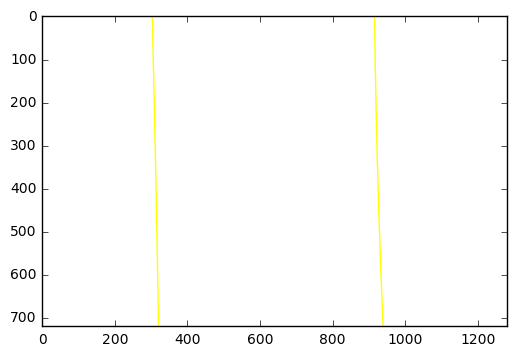

In [150]:
test_image = plt.imread("./test_images/straight_lines1.jpg")
_, Minv, warped_image = warp_image(combine_thresh(test_image))
display_the_fitted_line(warped_image)

### Rubric 2-5, finding lane curvature

In [112]:
def get_function_value(x, w):
    """
    return the function value of given second order polynomial coeffcients
    x, the x value
    w, the coefficients, tuple (w2, w1, w0)
    """
    return w[0]*x**2 + w[1]*x + w[2]        

def get_curvature(x, w):
    """
    return the value of curvature given the polynomial function
    x, the point at which the curvature is calculated, 
    w, the coefficients of the polynomial, tuple (w2, w1, w0)
    """
    return ((1 + (2*w[0]*x + w[1])**2)**1.5) / np.absolute(2*w[0])

def get_car_offset(x, left_fit, right_fit, image_width=700, road_width=3.7):
    left_x = get_function_value(x, left_fit)
    right_x = get_function_value(x, right_fit)
    lane_center_x = (left_x + right_x) / 2 
    image_center = image_width / 2
    offset = image_center - lane_center_x  # positive = right devation; negative = left deviation
    return offset * road_width / image_width # changes to meter            

def get_lane_distance(x, left_fit, right_fit, image_width=700, road_width=3.7):
    left_x = get_function_value(x, left_fit)
    right_x = get_function_value(x, right_fit)
    return (right_x - left_x) * road_width / image_width

def show_line(ploty, leftx, rightx, with_image_limit=True):
    plt.plot(leftx, ploty, color='green', linewidth=3)
    plt.plot(rightx, ploty, color='green', linewidth=3)
    if with_image_limit:
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

def show_fitted_line(pixel_y, fit, with_image_limit=True, scale=None):
    ploty = np.linspace(0, pixel_y-1, pixel_y)
    leftx = get_function_value(ploty, fit[0])
    rightx = get_function_value(ploty, fit[1])
    show_line(ploty, leftx, rightx, with_image_limit=with_image_limit)


In [145]:
def calculate_curvature(image_in_pixel, fit, points, image_in_meters=(3.7, 30)):
    pixel_x = image_in_pixel[0]
    pixel_y = image_in_pixel[1]
    meters_x = image_in_meters[0]
    meters_y = image_in_meters[1]   
    ym_per_pix = float(meters_y/pixel_y) # meters per pixel in y dimension
    xm_per_pix = float(meters_x/pixel_x) # meters per pixel in x dimension
    
    ploty = np.linspace(0, pixel_y-1, pixel_y)
    leftx = get_function_value(ploty, fit[0])
    rightx = get_function_value(ploty, fit[1])
    show_line(ploty, leftx, rightx)
    return get_curvature(pixel_y, fit[0]), get_curvature(pixel_y, fit[1])

    # fit the polynomial for the real lane 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2) 
    
    left_curverad = get_curvature(pixel_y, left_fit_cr)   
    right_curverad = get_curvature(pixel_y, right_fit_cr)
    print(left_curverad, 'm', right_curverad, 'm') 
    
    # calculate the devation
    devation = get_car_offset(pixel_y, fit[0], fit[1])
    
    return (left_curverad, right_curverad), devation

pixel
[ -7.07058472e-06   2.89786651e-02   3.03039760e+02] [  2.58256672e-05   1.41226188e-02   9.14939869e+02]
real
70752.991382 19437.0953978
3.26793077282


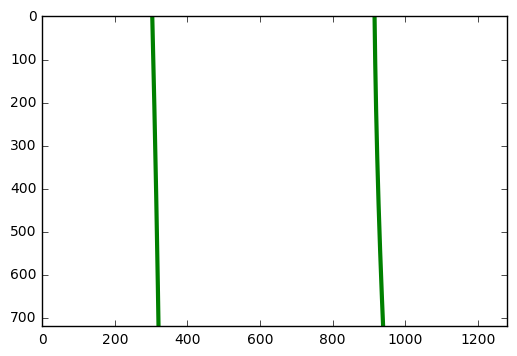

In [146]:
test_image = plt.imread("./test_images/straight_lines1.jpg")
_, Minv, warped_image = warp_image(combine_thresh(test_image))
fit, _, points = fit_line(warped_image)
# show_fitted_line(720, fit)
print("pixel")
print(fit[0], fit[1])
left_fit, right_fit = calculate_curvature((warped_image.shape[1], warped_image.shape[0]), fit, points)
print("real")
print(left_fit, right_fit)

print(get_lane_distance(720, fit[0], fit[1]))

### Rubric 2-6 pipline

In [153]:
def draw_filling(img, binary_warped, undistorted, Minv, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

def pipe_line(img, mtx, dist):
    # undistort the image using calibration matrix
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    # color transformation
    tranformed = combine_thresh(undistorted)

    # do warp
    _, Minv, warped_binary = warp_image(tranformed)
    
    # fit line
    fit = fit_line(warped_binary)
    
    return draw_filling(img, warped_binary, undistorted, Minv, fit[0], fit[1]) 

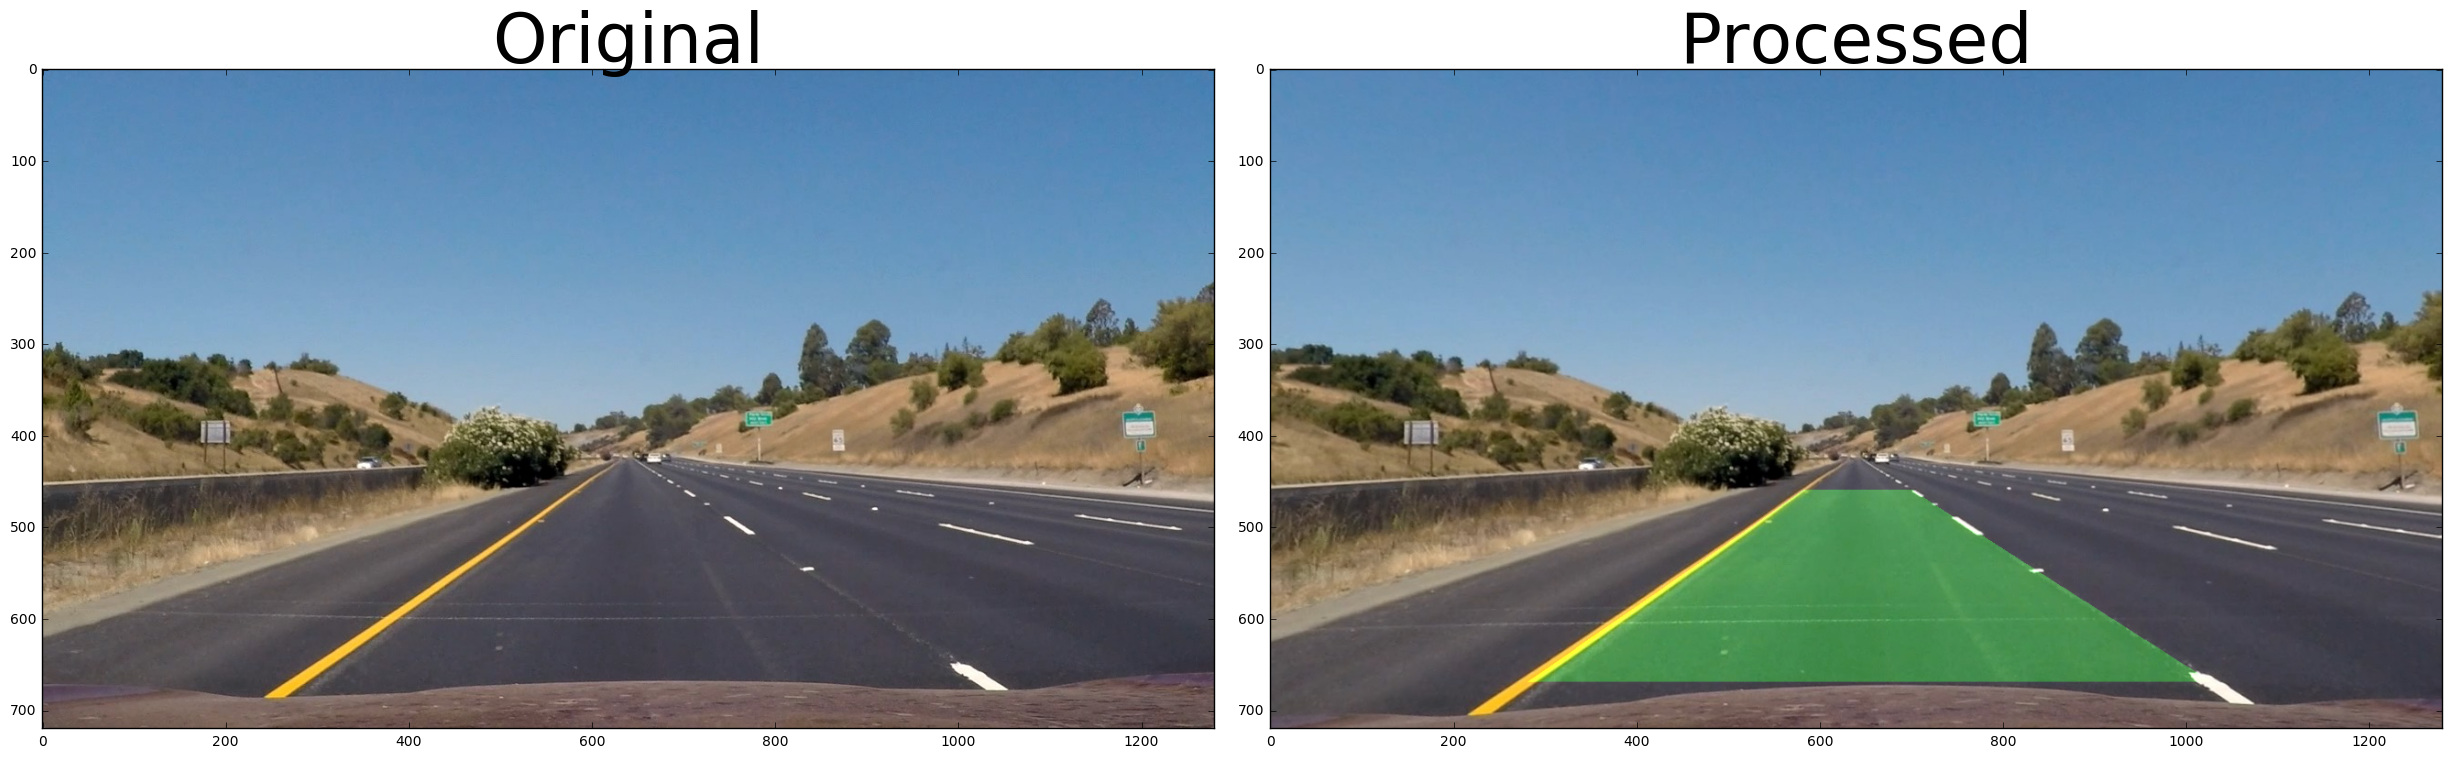

In [154]:
filled_image = pipe_line(test_image, mtx, dist)
display2images(test_image, filled_image)

### Rubric 3 Applying pipline to video

In [155]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [156]:
def process_image(image):
    result = pipe_line(image, mtx, dist)
    return result

In [157]:
output_video = "output_video_" + str(datetime.today()) + ".mp4"
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video_2017-04-16 14:55:44.875684.mp4
[MoviePy] Writing video output_video_2017-04-16 14:55:44.875684.mp4


100%|█████████▉| 1260/1261 [02:40<00:00,  8.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_2017-04-16 14:55:44.875684.mp4 

CPU times: user 2min 59s, sys: 29.8 s, total: 3min 29s
Wall time: 2min 41s


In [158]:
# output_video = "../project_output_video.mp4"
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))